# Build the Binary Logistic Regression Model

In [26]:
 # Import Libraries
 # Data and modeling
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from patsy import dmatrix
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import os
os.chdir(r"C:\Users\willi\GitHub\Heart_Attack_Risk_Assessment_PY\data\processed")

In [3]:
# Load the cleaned dataset

SADS_cleaned = pd.read_csv("SADS_cleaned.csv")
print("Data Set Loaded")
print(SADS_cleaned.head(5))

Data Set Loaded
   Age  Gender  Heart rate  Systolic blood pressure  Blood sugar  CK-MB  \
0   63       1          66                      160        160.0   1.80   
1   20       1          94                       98        296.0   6.75   
2   56       1          64                      160        270.0   1.99   
3   66       1          70                      120        270.0  13.87   
4   54       1          64                      112        300.0   1.08   

   Troponin  Result  
0     0.012       0  
1     1.060       1  
2     0.003       0  
3     0.122       1  
4     0.003       0  


In [11]:
# Seperate the features and target variable
X = SADS_cleaned.drop("Result", axis=1)
y = SADS_cleaned["Result"]

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Create the scaler object to make features like Troponin I and CK-MB comparable and preventing large values from dominating the model.

In [13]:
# Create the scaler object.
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and testing data

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

In [14]:
# Save the scaled datasets to disk
# Convert scaled data back to DataFrame for saving
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=X.columns)
x_test_df = pd.DataFrame(x_test_scaled, columns=X.columns)

Train_scaled = pd.concat([x_train_scaled_df, y_train.reset_index(drop=True)], axis=1)
Test_scaled = pd.concat([x_test_df, y_test.reset_index(drop=True)], axis=1)

Train_scaled.to_csv("Train_scaled.csv", index=False)
Test_scaled.to_csv("Test_scaled.csv", index=False)

print("✅ Scaled train and test sets saved to 'data/processed/' folder.")


✅ Scaled train and test sets saved to 'data/processed/' folder.


Step 4: Building the Logistic Regression Model

In [15]:
# Create Model

logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [16]:
# View the coefficients of the model
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logreg.coef_[0]
})

# Sort the coefficients by absolute value
coefficients["Abs_Coefficient"] = coefficients["Coefficient"].abs()
coefficients = coefficients.sort_values(by="Abs_Coefficient", ascending=False)

coefficients.drop("Abs_Coefficient", axis=1,)

,Feature,Coefficient
5,CK-MB,5.510719
6,Troponin,3.363479
0,Age,0.592767
1,Gender,0.213170
4,Blood sugar,-0.091109
3,Systolic blood pressure,-0.075439
2,Heart rate,0.032593


C:\Users\willi\AppData\Local\Temp\ipykernel_14432\2654286740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coefficients, palette="viridis")


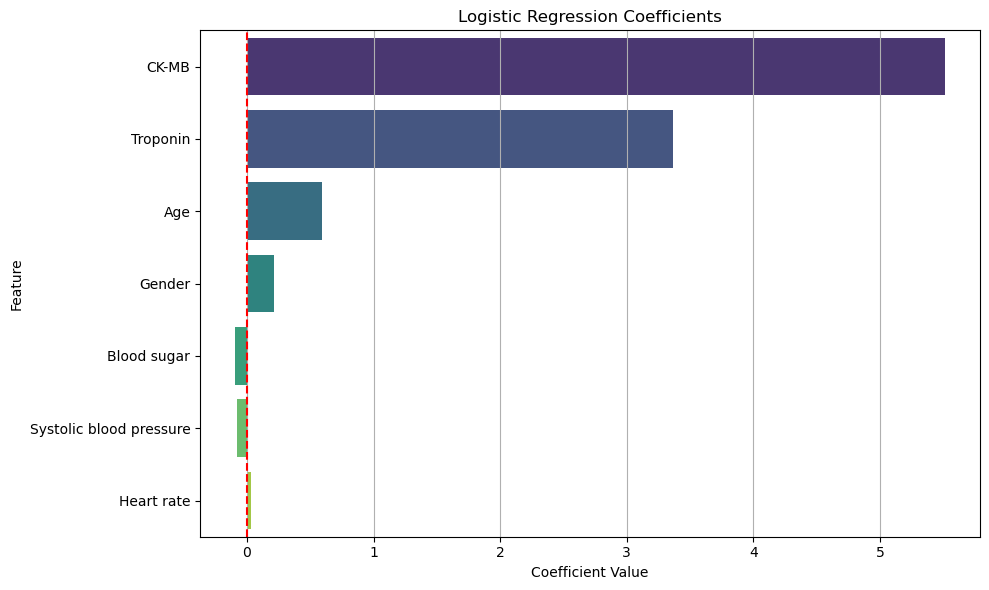

In [17]:
# Plot the coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=coefficients, palette="viridis")
plt.title("Logistic Regression Coefficients")
plt.xlabel("Coefficient Value") 
plt.ylabel("Feature")
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Step 5: Model Performance

In [18]:
# Make Predictions
y_pred = logreg.predict(x_test_scaled)
y_prob = logreg.predict_proba(x_test_scaled)[:, 1]


In [20]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Confusion Matrix:
 [[ 75  27]
 [ 24 138]]

Classification Report:
               precision    recall  f1-score   support

           0      0.758     0.735     0.746       102
           1      0.836     0.852     0.844       162

    accuracy                          0.807       264
   macro avg      0.797     0.794     0.795       264
weighted avg      0.806     0.807     0.806       264



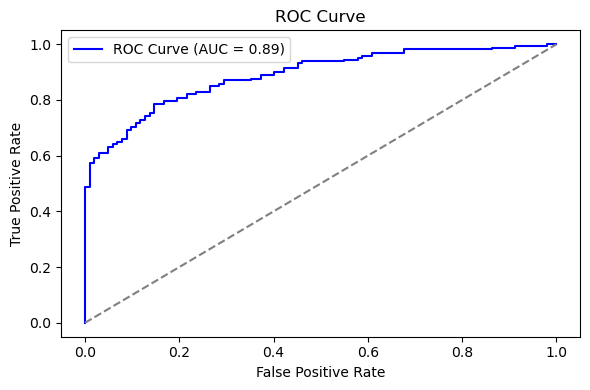

In [21]:
# ROC Curve and AUC

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# Train Model using statsmodels

# Reconstruct scaled X_train into a DataFrame with proper index
X_train_sm = pd.DataFrame(x_train_scaled, columns=X.columns, index=y_train.index)

# Add constant for intercept
X_train_sm = sm.add_constant(X_train_sm)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Print summary
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.432148
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 Result   No. Observations:                 1055
Model:                          Logit   Df Residuals:                     1047
Method:                           MLE   Df Model:                            7
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.3519
Time:                        17:29:25   Log-Likelihood:                -455.92
converged:                       True   LL-Null:                       -703.50
Covariance Type:            nonrobust   LLR p-value:                8.770e-103
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       5.0040      0.493     10.145      0.000       4.037  

In [25]:
# Run VIF for multicollinearity on the scaled training set
VIF_data = pd.DataFrame()
VIF_data["Feature"] = ["Intercept"] + list(X.columns)
VIF_data["VIF"] = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]

print("\nVIF Data:\n", VIF_data)


VIF Data:
                    Feature       VIF
0                Intercept  1.000000
1                      Age  1.022109
2                   Gender  1.015931
3               Heart rate  1.002210
4  Systolic blood pressure  1.005261
5              Blood sugar  1.001970
6                    CK-MB  1.001170
7                 Troponin  1.016995


In [27]:
# Cross Validation

cv_scores = cross_val_score(logreg, Train_scaled, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [1.         1.         1.         1.         0.99526066]
Mean CV Accuracy: 0.9990521327014218


Average Generalisation sits at 99.91%.  Model seems to generalise well to unseen training data and is not overfitting within the training set.

Based on the earlier Confusion Matrix and ROC curve output, we can confirm that performance is in line with our earlier findings.

In [29]:
# Set directory for saving the model
os.chdir(r"C:\Users\willi\GitHub\Heart_Attack_Risk_Assessment_PY\models")

In [31]:
# Save the Model and Scaler for Deployment


# Re-train logistic regression on full training set (if not already done)
final_model = LogisticRegression(max_iter=1000, solver='liblinear')
final_model.fit(x_train_scaled, y_train)

# Save model to the models folder
joblib.dump(final_model, 'logreg_heart_attack_model.pkl')

# Save the scaler used to scale features
joblib.dump(scaler, 'standard_scaler.pkl')

print("✅ Model and scaler successfully saved to 'models/'")

✅ Model and scaler successfully saved to 'models/'
